参考  
[言語処理100本ノック 2020 第10章: 機械翻訳 (90-98)](https://qiita.com/nymwa/items/867e05a43060d036a174)  
@nymwa

In [1]:
%cd '/content/drive/My Drive/Colab/NLP100/'
!pwd

/content/drive/My Drive/Colab/NLP100
/content/drive/My Drive/Colab/NLP100


In [2]:
!pip install fairseq ginza

     |████████████████████████████████| 307kB 10.5MB/s 
     |████████████████████████████████| 61kB 6.6MB/s 
     |████████████████████████████████| 54.9MB 57kB/s 
     |████████████████████████████████| 81kB 12.4MB/s 
     |████████████████████████████████| 44.8MB 70kB/s 
     |████████████████████████████████| 481kB 45.9MB/s 
  Created wheel for fairseq: filename=fairseq-0.9.0-cp36-cp36m-linux_x86_64.whl size=2035359 sha256=cfbaea54e561c80d531f87828d77651ae34985336f183a8356b5e9590ac1e23b
  Stored in directory: /root/.cache/pip/wheels/37/3e/1b/0fa30695dcba41e4b0088067fa40f3328d1e8ee78c22cd4766
  Created wheel for ginza: filename=ginza-3.1.2-cp36-none-any.whl size=17311 sha256=180b97ac11edd0be6aafd255be964d52f56013318ad2ef596631c9aa59d809b5
  Stored in directory: /root/.cache/pip/wheels/70/8d/57/f089078acc0dbaebffc08c178e9f20924fa794c114ad36f7f7
  Created wheel for ja-ginza: filename=ja_ginza-3.1.0-cp36-none-any.whl size=54963619 sha256=e38ba44bdc1a0782d524f1e5b6f2bf67e52ca951f303e16f

In [0]:
import re
import spacy
import matplotlib.pyplot as plt

# 90. データの準備

In [0]:
for src, dst in [
    ('train.ginza.ja', 'train.spacy.ja'),
    ('dev.ginza.ja', 'dev.spacy.ja'),
    ('test.ginza.ja', 'test.spacy.ja'),
]:
    with open(src) as f:
        lst = []
        tmp = []
        for x in f:
            x = x.strip()
            if x == 'EOS':
                lst.append(' '.join(tmp))
                tmp = []
            elif x != '':
                tmp.append(x.split('\t')[0])
    with open(dst, 'w') as f:
        for line in lst:
            print(line, file=f)

In [0]:


nlp = spacy.load('en')
for src, dst in [
    ('kftt-data-1.0/data/orig/kyoto-train.en', 'train.spacy.en'),
    ('kftt-data-1.0/data/orig/kyoto-dev.en', 'dev.spacy.en'),
    ('kftt-data-1.0/data/orig/kyoto-test.en', 'test.spacy.en'),
]:
    with open(src) as f, open(dst, 'w') as g:
        for x in f:
            x = x.strip()
            x = re.sub(r'\s+', ' ', x)
            x = nlp.make_doc(x)
            x = ' '.join([doc.text for doc in x])
            print(x, file=g)

# 91. 機械翻訳モデルの訓練

In [0]:
!fairseq-preprocess -s ja -t en \
    --trainpref train.spacy \
    --validpref dev.spacy \
    --destdir data91  \
    --thresholdsrc 5 \
    --thresholdtgt 5 \
    --workers 20

Namespace(align_suffix=None, alignfile=None, bpe=None, cpu=False, criterion='cross_entropy', dataset_impl='mmap', destdir='data91', empty_cache_freq=0, fp16=False, fp16_init_scale=128, fp16_scale_tolerance=0.0, fp16_scale_window=None, joined_dictionary=False, log_format=None, log_interval=1000, lr_scheduler='fixed', memory_efficient_fp16=False, min_loss_scale=0.0001, no_progress_bar=False, nwordssrc=-1, nwordstgt=-1, only_source=False, optimizer='nag', padding_factor=8, seed=1, source_lang='ja', srcdict=None, target_lang='en', task='translation', tensorboard_logdir='', testpref=None, tgtdict=None, threshold_loss_scale=None, thresholdsrc=5, thresholdtgt=5, tokenizer=None, trainpref='train.spacy', user_dir=None, validpref='dev.spacy', workers=20)
| [ja] Dictionary: 60247 types
| [ja] train.spacy.ja: 440288 sents, 11298955 tokens, 1.41% replaced by <unk>
| [ja] Dictionary: 60247 types
| [ja] dev.spacy.ja: 1166 sents, 25550 tokens, 1.54% replaced by <unk>
| [en] Dictionary: 55495 types
| [

In [0]:
!fairseq-train data91 \
    --fp16 \
    --save-dir save91 \
    --max-epoch 10 \
    --arch transformer --share-decoder-input-output-embed \
    --optimizer adam --clip-norm 1.0 \
    --lr 1e-3 --lr-scheduler inverse_sqrt --warmup-updates 2000 \
    --update-freq 1 \
    --dropout 0.2 --weight-decay 0.0001 \
    --criterion label_smoothed_cross_entropy --label-smoothing 0.1 \
    --max-tokens 8000 > 91.log

| epoch 001:   0% 2/1807 [00:01<24:48,  1.21it/s]/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


# 92. 機械翻訳モデルの適用

In [0]:
!fairseq-interactive --path save91/checkpoint10.pt data91 < test.spacy.ja | grep '^H' 

/pytorch/aten/src/ATen/native/BinaryOps.cpp:66: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.
H-0	-0.4813351631164551	<unk>
H-1	-0.7359832525253296	Dogen was a Zen monk in the early Kamakura period .
H-2	-0.567832350730896	Soto sect
H-3	-0.8001871109008789	He was commonly known as ' <unk> . '
H-4	-0.8984081745147705	It is also called " <unk> . "
H-5	-0.7246667146682739	His shigo ( a posthumous name ) was <unk> .
H-6	-0.7881256341934204	His imina ( personal name ) is Dogen .
H-7	-1.206981897354126	It is a custom to use the word " <unk> " ( literally , " a way of eating " ) in Japan .
H-8	-0.9509299993515015	It is said that this is the origin of the story .
H-9	-0.7908077239990234	He was the eldest son of Kanezane KUJO , but his real name is unknown .
H-10	-0.7559925317764282	Her father was FUJIWARA no Tadamichi , who was the head of the 

In [0]:
!fairseq-interactive --path save91/checkpoint10.pt data91 < test.spacy.ja | grep '^H' | cut -f3 > 92.out

/pytorch/aten/src/ATen/native/BinaryOps.cpp:66: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


# 93. BLEUスコアの計測

In [0]:
!fairseq-score --sys 92.out --ref test.spacy.en

Namespace(ignore_case=False, order=4, ref='test.spacy.en', sacrebleu=False, sentence_bleu=False, sys='92.out')
BLEU4 = 2.38, 39.6/10.2/4.2/2.2 (BP=0.303, ratio=0.456, syslen=12591, reflen=27625)


# 94. ビーム探索

In [0]:
%%bash
for N in `seq 21 100` ; do
    fairseq-interactive --path save91/checkpoint10.pt --beam $N data91 < test.spacy.ja | grep '^H' | cut -f3 > 94.$N.out
done



In [3]:
%%bash
for N in `seq 21 100` ; do
    fairseq-score --sys 94.$N.out --ref test.spacy.en > 94.$N.score
done

Traceback (most recent call last):
  File "/usr/local/bin/fairseq-score", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.6/dist-packages/fairseq_cli/score.py", line 84, in main
    score(f)
  File "/usr/local/lib/python3.6/dist-packages/fairseq_cli/score.py", line 78, in score
    print(scorer.result_string(args.order))
  File "/usr/local/lib/python3.6/dist-packages/fairseq/bleu.py", line 127, in result_string
    return fmt.format(order, self.score(order=order), *bleup,
  File "/usr/local/lib/python3.6/dist-packages/fairseq/bleu.py", line 103, in score
    return self.brevity() * math.exp(psum / order) * 100
  File "/usr/local/lib/python3.6/dist-packages/fairseq/bleu.py", line 117, in brevity
    r = self.stat.reflen / self.stat.predlen
ZeroDivisionError: division by zero
Traceback (most recent call last):
  File "/usr/local/bin/fairseq-score", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.6/dist-packages/fairseq_cli/score.py", line 4

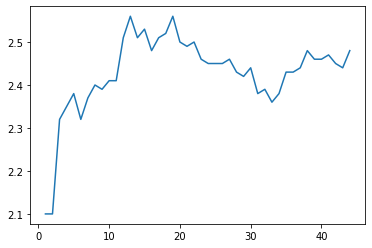

In [7]:
def read_score(filename):
    with open(filename) as f:
        x = f.readlines()[1]
        x = re.search(r'(?<=BLEU4 = )\d*\.\d*(?=,)', x)
        return float(x.group())

xs = range(1, 45)
ys = [read_score(f'94.{x}.score') for x in xs]
plt.plot(xs, ys)
plt.show()